In [1]:
## import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import time
from typing import List, Optional, Dict, Tuple
import math
from itertools import combinations
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn_extra.cluster import KMedoids
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    adjusted_mutual_info_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)
from sklearn.manifold import TSNE
import gower
import prince
import hdbscan
from IPython.display import display
import seaborn as sns

sns.set_style("whitegrid")

import warnings

warnings.filterwarnings("ignore")

import os

os.environ.setdefault("OMP_NUM_THREADS", "8")

'8'

In [2]:
# data input/output
# data_path = "./survey_results_public.csv"
# data_name = "StackOverflow"
data_path = "./aijobs_salary.csv"
data_name = "AIJobs"
out_dir = "experiments/" + data_name
os.makedirs(out_dir, exist_ok=True)

# load and inspect data (before selecting features)
df_raw = pd.read_csv(data_path, low_memory=False)
print("First 5 rows:")
display(df_raw.head(5))
print("\nData Types:")
df_raw.info()
print("\nStatistics:")
display(df_raw.describe(include="all").T)

First 5 rows:


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,SE,FT,Software Engineer,218900,USD,218900,US,100,US,M
1,2025,SE,FT,Software Engineer,186065,USD,186065,US,100,US,M
2,2025,SE,FT,System Engineer,158000,USD,158000,US,0,US,M
3,2025,SE,FT,System Engineer,140000,USD,140000,US,0,US,M
4,2025,SE,FT,Data Engineer,164600,USD,164600,US,0,US,M



Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148521 entries, 0 to 148520
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   work_year           148521 non-null  int64 
 1   experience_level    148521 non-null  object
 2   employment_type     148521 non-null  object
 3   job_title           148521 non-null  object
 4   salary              148521 non-null  int64 
 5   salary_currency     148521 non-null  object
 6   salary_in_usd       148521 non-null  int64 
 7   employee_residence  148521 non-null  object
 8   remote_ratio        148521 non-null  int64 
 9   company_location    148521 non-null  object
 10  company_size        148521 non-null  object
dtypes: int64(4), object(7)
memory usage: 12.5+ MB

Statistics:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
work_year,148521.0,NaN,NaN,NaN,2024.424196,0.673689,2020.0,2024.0,2025.0,2025.0,2025.0
experience_level,148521,4,SE,85846,NaN,NaN,NaN,NaN,NaN,NaN,NaN
employment_type,148521,4,FT,147623,NaN,NaN,NaN,NaN,NaN,NaN,NaN
job_title,148521,419,Data Scientist,18503,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salary,148521.0,NaN,NaN,NaN,162883.41518,209271.277042,14000.0,106000.0,147000.0,199000.0,30400000.0
salary_currency,148521,26,USD,140386,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salary_in_usd,148521.0,NaN,NaN,NaN,157518.521125,74167.537288,15000.0,105943.0,146100.0,198000.0,800000.0
employee_residence,148521,104,US,132900,NaN,NaN,NaN,NaN,NaN,NaN,NaN
remote_ratio,148521.0,NaN,NaN,NaN,20.881895,40.578639,0.0,0.0,0.0,0.0,100.0
company_location,148521,97,US,132963,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# set candidate features for EDAV/clustering
# candidate_numerical = ["ConvertedCompYearly", "YearsCodePro"]
# candidate_categorical = ["RemoteWork", "OrgSize"]
candidate_numerical = ["salary_in_usd", "remote_ratio"]
candidate_categorical = [
    "job_title",
    "company_size",
]


# helper function for basic EDAV
def basic_edav(df: pd.DataFrame, features: List[str]) -> None:
    cols = [c for c in features if c in df.columns]
    print(f"\nEDAV for: {cols}")
    print("\nFirst 5 rows:")
    display(df[cols].head(5))
    print("\nData Types:")
    display(df[cols].info())
    print("\nStatistics:")
    display(df[cols].describe(include="all").T)

    for c in cols:
        print(f"\nFirst 50 value counts for '{c}':")
        display(df[c].value_counts(dropna=False).head(50))

    # calculate missingness
    missing = df[cols].isna().sum()
    missing_percent = missing / len(df) * 100
    display(
        pd.DataFrame(
            {"Missing Records": missing, "Percentage Missing": missing_percent}
        )
    )


# run EDAV on selected features
basic_edav(df_raw, candidate_numerical + candidate_categorical)


EDAV for: ['salary_in_usd', 'remote_ratio', 'job_title', 'company_size']

First 5 rows:


,salary_in_usd,remote_ratio,job_title,company_size
0,218900,100,Software Engineer,M
1,186065,100,Software Engineer,M
2,158000,0,System Engineer,M
3,140000,0,System Engineer,M
4,164600,0,Data Engineer,M



Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148521 entries, 0 to 148520
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   salary_in_usd  148521 non-null  int64 
 1   remote_ratio   148521 non-null  int64 
 2   job_title      148521 non-null  object
 3   company_size   148521 non-null  object
dtypes: int64(2), object(2)
memory usage: 4.5+ MB


None


Statistics:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
salary_in_usd,148521.0,NaN,NaN,NaN,157518.521125,74167.537288,15000.0,105943.0,146100.0,198000.0,800000.0
remote_ratio,148521.0,NaN,NaN,NaN,20.881895,40.578639,0.0,0.0,0.0,0.0,100.0
job_title,148521,419,Data Scientist,18503,NaN,NaN,NaN,NaN,NaN,NaN,NaN
company_size,148521,3,M,144447,NaN,NaN,NaN,NaN,NaN,NaN,NaN



First 50 value counts for 'salary_in_usd':


salary_in_usd
160000    2615
150000    2522
110000    2466
180000    2016
200000    1949
100000    1945
120000    1927
140000    1810
130000    1715
170000    1401
90000     1315
250000    1166
80000     1136
220000    1100
190000    1092
145000    1087
175000    1069
125000    1021
135000     990
115000     912
85000      813
185000     801
75000      785
70000      728
136000     724
165000     709
230000     689
95000      686
210000     684
155000     674
105000     612
225000     605
300000     598
240000     529
60000      511
168000     478
172000     458
260000     448
138000     444
148000     430
65000      409
117000     403
176000     399
128000     389
215000     376
252000     375
112000     368
173000     367
234000     357
144000     354
Name: count, dtype: int64


First 50 value counts for 'remote_ratio':


remote_ratio
0      117343
100     30850
50        328
Name: count, dtype: int64


First 50 value counts for 'job_title':


job_title
Data Scientist                     18503
Software Engineer                  16666
Data Engineer                      16136
Data Analyst                       13589
Engineer                           10750
Machine Learning Engineer           8777
Manager                             7617
Analyst                             5224
Research Scientist                  3412
Product Manager                     2524
Applied Scientist                   2349
Associate                           2323
Data Architect                      2190
Analytics Engineer                  2091
AI Engineer                         1967
Research Engineer                   1717
Consultant                          1345
Data Manager                        1053
Developer                           1014
Data Specialist                      966
Solutions Architect                  952
Business Intelligence Engineer       930
Engineering Manager                  894
Systems Engineer                     824
Archit


First 50 value counts for 'company_size':


company_size
M    144447
L      3857
S       217
Name: count, dtype: int64

,Missing Records,Percentage Missing
salary_in_usd,0,0.0
remote_ratio,0,0.0
job_title,0,0.0
company_size,0,0.0


In [4]:
# CONFIG AND DATA PREPROCESSING/FEATURE ENGINEERING
COLLAPSE_CAT_THRESHOLD = (
    0.02  # collapse categories below threshold to new 'Other' category
)
RANDOM_STATE = 42
SUBSET_SIZES = {"small": 2000, "medium": 5000, "large": 10000}  # add "full": None for all data
K_RANGE = range(2, 11)                      # number of clusters in experiments
MAX_GOWER_N = 25000                         # use Gower only for n below this value
HDBSCAN_MIN_CLUSTER_SIZES = [20, 50, 100, 200]       # min cluster size values for HDBSCAN
FAMD_COMPONENTS = 20                        # number of components for FAMD
STABILITY_REPEATS = 3                       # number of times to repeat experiment
# GROUND_TRUTH_FEATURE = "Age"                # proxy feature for ARI/AMI
GROUND_TRUTH_FEATURE = "experience_level"   # proxy feature for ARI/AMI


# custom helpers
def parse_years(val):
    """Converts YearsCodePro text values to number format."""
    if pd.isna(val):
        return np.nan

    s = str(val).strip().lower()

    if s.startswith("less than 1"):
        return 0.5

    if s.startswith("more than 50"):
        return 55.0

    try:
        return float(s)

    except Exception:
        return np.nan


def get_ground_truth_labels(
    df: pd.DataFrame, ground_truth_col: Optional[str]
) -> Optional[np.ndarray]:
    """Get proxy ground truth labels for Age."""
    if ground_truth_col is None or ground_truth_col not in df.columns:
        return None

    val = df[ground_truth_col]
    # safe check
    if pd.api.types.is_numeric_dtype(val):
        bins = [0, 25, 35, 45, 55, 200]
        try:
            labels = pd.cut(
                val.fillna(-1).replace(-1, np.nan).astype(float),
                bins=bins,
                labels=False,
            )
            return labels.fillna(-1).astype(int).to_numpy()
        except Exception:
            return pd.Categorical(val.fillna("Missing")).codes
    else:
        return pd.Categorical(val.fillna("Missing")).codes


# custom preprocessing
# df_raw = df_raw[df_raw["ConvertedCompYearly"].notna()].reset_index(drop=True)
# df_raw["YearsCodePro_Num"] = df_raw["YearsCodePro"].apply(parse_years)


# set final features after EDAV
# numerical_features = ["ConvertedCompYearly", "YearsCodePro_Num"]
# categorical_features = ["RemoteWork", "OrgSize"]
numerical_features = ["salary_in_usd", "remote_ratio"]
categorical_features = [
    "job_title",
    "company_size",
]

In [5]:
# helper functions and distance measures/famd
def collapse_categories(
    df: pd.DataFrame, cols: List[str], threshold: float = COLLAPSE_CAT_THRESHOLD
) -> pd.DataFrame:
    """Collapses category values below threshold to 'Other'."""
    df_copy = df.copy()
    for c in cols:
        # safety check
        if c not in df_copy.columns:
            continue

        frequencies = df_copy[c].value_counts(normalize=True)
        rares = set(frequencies[frequencies < threshold].index)
        if rares:
            df_copy[c] = df_copy[c].where(~df_copy[c].isin(rares), other="Other")

    return df_copy


def prepare_mixed_df(
    df: pd.DataFrame,
    num_cols: List[str],
    cat_cols: List[str],
    robust_scaler: bool = False,
) -> pd.DataFrame:
    """Returns mixed-type df with processed numerical and categorical columns."""
    # safe check
    num_cols_present = [c for c in num_cols if c in df.columns]
    cat_cols_present = [c for c in cat_cols if c in df.columns]
    df_mixed = df[num_cols_present + cat_cols_present].copy()

    # numerical columns -> coerce to float and median-impute
    for c in num_cols_present:
        df_mixed[c] = pd.to_numeric(df_mixed[c], errors="coerce")
        median = df_mixed[c].median()
        df_mixed[c] = df_mixed[c].fillna(median)

    # categorical columns -> fill missing with new 'Missing' label convert to string
    for c in cat_cols_present:
        df_mixed[c] = df_mixed[c].fillna("Missing").astype(str)

    # apply robust scaler on numerical columns (not for gower)
    scaler = None
    if robust_scaler and len(num_cols_present) > 0:
        scaler = RobustScaler()
        df_mixed[num_cols_present] = scaler.fit_transform(df_mixed[num_cols_present])

    return df_mixed, scaler


def compute_gower(df_mixed: pd.DataFrame) -> np.ndarray:
    """Computes Gower distance matrix."""
    return gower.gower_matrix(df_mixed)


def compute_famd(
    df_mixed: pd.DataFrame,
    n_components: int = FAMD_COMPONENTS,
    random_state: int = RANDOM_STATE,
):
    """Computes FAMD embedding or MCA if all features are categorical."""
    df_copy = df_mixed.copy()

    try:
        famd = prince.FAMD(n_components=n_components, random_state=random_state)
        embed = famd.fit_transform(df_copy)
        model = famd

    except ValueError as e:
        if "qualitative" in str(e).lower():
            # if all categorical, use MCA
            mca = prince.MCA(n_components=n_components, random_state=random_state)
            embed = mca.fit_transform(df_copy)
            model = mca
        else:
            raise

    # return numpy array
    if hasattr(embed, "values"):
        embed = embed.values

    return embed, model


def time_and_run(func, *args, **kwargs):
    """Wrapper for timing algorithm runtime."""
    t0 = time.time()
    labels, model = func(*args, **kwargs)
    elapsed = time.time() - t0
    return labels, model, elapsed

In [6]:
# clustering algorithms


def run_k_medoids(D: np.ndarray, k: int, random_state: int = RANDOM_STATE):
    model = KMedoids(
        n_clusters=k,
        metric="precomputed",
        init="k-medoids++",
        random_state=random_state,
    )
    labels = model.fit_predict(D)
    return labels, model


def run_k_prototypes(
    df_mixed: pd.DataFrame,
    cat_cols: List[str],
    k: int,
    random_state: int = RANDOM_STATE,
):
    X = df_mixed.to_numpy(dtype=object)
    cat_idx = [df_mixed.columns.get_loc(c) for c in cat_cols if c in df_mixed.columns]
    model = KPrototypes(n_clusters=k, init="Huang", n_init=3, random_state=random_state)
    labels = model.fit_predict(X, categorical=cat_idx)
    return labels, model


def run_agglomerative(D: np.ndarray, k: int):
    model = AgglomerativeClustering(
        n_clusters=k, metric="precomputed", linkage="average"
    )
    labels = model.fit_predict(D)
    return labels, model


def run_famd_kmeans(X_famd: np.ndarray, k: int, random_state: int = RANDOM_STATE):
    model = KMeans(n_clusters=k, n_init="auto", random_state=random_state)
    labels = model.fit_predict(X_famd)
    return labels, model


def run_hdbscan(data, min_cluster_size: int, precomputed: bool = False):
    if precomputed:
        # use gower
        D = np.asarray(data, dtype=np.float64)
        model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, metric="precomputed")
        labels = model.fit_predict(D)
    else:
        # use FAMD
        X = np.asarray(data, dtype=np.float64)
        model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, metric="euclidean")
        labels = model.fit_predict(X)
    return labels, model

In [7]:
# evaluation metrics


def evaluate_clustering(
    labels,
    data_for_sil,
    X_emb,
    precomputed=False,
    ground_truth_labels=None,
):
    sil_common = sil_native = float("nan")
    ari = ami = float("nan")
    ch = db = float("nan")
    # calculate silhouette score
    mask = labels != -1
    if mask.sum() > 1 and len(set(labels[mask])) > 1:
        try:
            # famd
            sil_common = float(
                silhouette_score(X_emb[mask], labels[mask], metric="euclidean")
            )

            if precomputed:
                # gower
                sil_native = float(
                    silhouette_score(
                        data_for_sil[mask][:, mask], labels[mask], metric="precomputed"
                    )
                )
            else:
                # famd
                sil_native = float(
                    silhouette_score(
                        data_for_sil[mask], labels[mask], metric="euclidean"
                    )
                )
        except Exception:
            sil_native = sil_common = float("nan")

    if ground_truth_labels is not None:
        try:
            gt = np.asarray(ground_truth_labels)
            if gt.shape[0] != labels.shape[0]:
                ari = ami = float("nan")
            else:
                valid = mask & (~pd.isna(gt))
                if valid.sum() > 1 and len(set(labels[valid])) > 1:
                    ari = float(adjusted_rand_score(gt[valid], labels[valid]))
                    ami = float(adjusted_mutual_info_score(gt[valid], labels[valid]))
                else:
                    ari = ami = float("nan")
        except Exception:
            ari = ami = float("nan")

    # calculate ch and db scores
    try:
        if not precomputed and data_for_sil is not None:
            if mask.sum() > 1 and len(set(labels[mask])) > 1:
                ch = float(calinski_harabasz_score(data_for_sil[mask], labels[mask]))
                db = float(davies_bouldin_score(data_for_sil[mask], labels[mask]))
        else:
            if X_emb is not None:
                if mask.sum() > 1 and len(set(labels[mask])) > 1:
                    ch = float(calinski_harabasz_score(X_emb[mask], labels[mask]))
                    db = float(davies_bouldin_score(X_emb[mask], labels[mask]))
            else:
                ch = db = float("nan")
    except Exception:
        ch = db = float("nan")

    return {
        "silhouette_native": sil_native,
        "silhouette_common": sil_common,
        "ARI": ari,
        "AMI": ami,
        "CH": ch,
        "DB": db,
    }

In [8]:
# experiment loop

OUT_DIR = Path(out_dir)
OUT_DIR.mkdir(parents=True, exist_ok=True)

# save results for comparison and visualisation
results = []
subset_cache = {}

df = df_raw.copy()

for subset_label, target_n in SUBSET_SIZES.items():
    # repeat for all subset sizes
    if target_n is None:
        n_use = len(df)
    else:
        n_use = min(target_n, len(df))
    print(f"\nSubset: {subset_label}, n={n_use}")

    # get sample subset
    df_sub = df.sample(n=n_use, random_state=RANDOM_STATE).reset_index(drop=True)

    # extract ground truth labels
    ground_truth_labels = get_ground_truth_labels(df_sub, GROUND_TRUTH_FEATURE)

    # build mixed df
    df_mixed_gower, _ = prepare_mixed_df(
        df_sub, numerical_features, categorical_features, robust_scaler=False
    )
    df_mixed_scaled, _ = prepare_mixed_df(
        df_sub, numerical_features, categorical_features, robust_scaler=True
    )

    # collapse rare categories
    df_mixed_gower = collapse_categories(
        df_mixed_gower, categorical_features, threshold=COLLAPSE_CAT_THRESHOLD
    )
    df_mixed_scaled = collapse_categories(
        df_mixed_scaled, categorical_features, threshold=COLLAPSE_CAT_THRESHOLD
    )

    subset_size = len(df_mixed_gower)

    # compute gower if below max n
    use_gower = subset_size <= MAX_GOWER_N
    D = None
    if use_gower:
        print("Computing Gower distance matrix")
        D = compute_gower(df_mixed_gower)

    # compute FAMD
    print("Computing FAMD / MCA embedding")
    X_famd, famd_model = compute_famd(
        df_mixed_scaled, n_components=FAMD_COMPONENTS, random_state=RANDOM_STATE
    )

    # also compute FAMD with non-scaled data (for CH/DB metrics)
    print("Computing Gower FAMD / MCA embedding for CH/DB metrics")
    X_famd_gower, _ = compute_famd(
        df_mixed_gower, n_components=FAMD_COMPONENTS, random_state=RANDOM_STATE
    )

    # save labels
    labels_store = {}

    # run clustering algorithms
    for k in K_RANGE:
        print(f"k = {k}, running k_prototypes")
        try:
            labels, _, clustering_time = time_and_run(
                run_k_prototypes,
                df_mixed_scaled,
                categorical_features,
                int(k),
                RANDOM_STATE,
            )
        except Exception as e:
            labels = np.full(subset_size, -1, dtype=int)
            clustering_time = 0.0

        labels_store[("k_prototypes", int(k))] = np.asarray(labels)
        metrics = evaluate_clustering(
            labels,
            D,
            X_emb=X_famd_gower,
            precomputed=True,
            ground_truth_labels=ground_truth_labels,
        )
        metrics["clustering_runtime"] = float(clustering_time)
        results.append(
            {
                **{
                    "dataset": data_name,
                    "subset": subset_label,
                    "algorithm": "k_prototypes",
                    "param": int(k),
                    "subset_size": subset_size,
                },
                **metrics,
            }
        )

        if use_gower:
            print(f"k = {k}, running agg_gower")
            try:
                labels, _, clustering_time = time_and_run(run_agglomerative, D, int(k))
            except Exception as e:
                labels = np.full(subset_size, -1, dtype=int)
                clustering_time = 0.0

            labels_store[("agg_gower", int(k))] = np.asarray(labels)
            metrics = evaluate_clustering(
                labels,
                D,
                X_emb=X_famd_gower,
                precomputed=True,
                ground_truth_labels=ground_truth_labels,
            )
            metrics["clustering_runtime"] = float(clustering_time)
            results.append(
                {
                    **{
                        "dataset": data_name,
                        "subset": subset_label,
                        "algorithm": "agg_gower",
                        "param": int(k),
                        "subset_size": subset_size,
                    },
                    **metrics,
                }
            )

            print(f"k = {k}, running k_medoids")
            try:
                labels, _, clustering_time = time_and_run(
                    run_k_medoids, D, int(k), RANDOM_STATE
                )
            except Exception as e:
                labels = np.full(subset_size, -1, dtype=int)
                clustering_time = 0.0

            labels_store[("k_medoids", int(k))] = np.asarray(labels)
            metrics = evaluate_clustering(
                labels,
                D,
                X_emb=X_famd_gower,
                precomputed=True,
                ground_truth_labels=ground_truth_labels,
            )
            metrics["clustering_runtime"] = float(clustering_time)
            results.append(
                {
                    **{
                        "dataset": data_name,
                        "subset": subset_label,
                        "algorithm": "k_medoids",
                        "param": int(k),
                        "subset_size": subset_size,
                    },
                    **metrics,
                }
            )

        print(f"k = {k}, running famd_kmeans")
        try:
            labels, _, clustering_time = time_and_run(
                run_famd_kmeans, X_famd, int(k), random_state=RANDOM_STATE
            )
        except Exception as e:
            labels = np.full(subset_size, -1, dtype=int)
            clustering_time = 0.0

        labels_store[("famd_kmeans", int(k))] = np.asarray(labels)
        metrics = evaluate_clustering(
            labels,
            X_famd,
            X_famd,
            precomputed=False,
            ground_truth_labels=ground_truth_labels,
        )
        metrics["clustering_runtime"] = float(clustering_time)
        results.append(
            {
                **{
                    "dataset": data_name,
                    "subset": subset_label,
                    "algorithm": "famd_kmeans",
                    "param": int(k),
                    "subset_size": subset_size,
                },
                **metrics,
            }
        )

    for mcs in HDBSCAN_MIN_CLUSTER_SIZES:
        if use_gower:
            print(f"HDBSCAN (Gower) min_cluster_size={mcs}")
            try:
                labels, _, clustering_time = time_and_run(
                    run_hdbscan, D, int(mcs), precomputed=use_gower
                )
            except Exception as e:
                labels = np.full(subset_size, -1, dtype=int)
                clustering_time = 0.0

            labels_store[("hdbscan_gower", int(mcs))] = np.asarray(labels)
            metrics = evaluate_clustering(
                labels,
                D,
                X_emb=X_famd_gower,
                precomputed=True,
                ground_truth_labels=ground_truth_labels,
            )
            metrics["clustering_runtime"] = float(clustering_time)
            results.append(
                {
                    **{
                        "dataset": data_name,
                        "subset": subset_label,
                        "algorithm": "hdbscan_gower",
                        "param": int(mcs),
                        "subset_size": subset_size,
                    },
                    **metrics,
                }
            )

        print(f"HDBSCAN (FAMD) min_cluster_size={mcs}")
        try:
            labels, _, clustering_time = time_and_run(
                run_hdbscan, X_famd, int(mcs), False
            )
        except Exception as e:
            labels = np.full(subset_size, -1, dtype=int)
            clustering_time = 0.0

        labels_store[("hdbscan_famd", int(mcs))] = np.asarray(labels)
        metrics = evaluate_clustering(
            labels,
            X_famd,
            X_famd,
            precomputed=False,
            ground_truth_labels=ground_truth_labels,
        )
        metrics["clustering_runtime"] = float(clustering_time)
        results.append(
            {
                **{
                    "dataset": data_name,
                    "subset": subset_label,
                    "algorithm": "hdbscan_famd",
                    "param": int(mcs),
                    "subset_size": subset_size,
                },
                **metrics,
            }
        )

    subset_cache[subset_label] = {
        "labels_store": labels_store,
        "X_famd": X_famd,
        "df_mixed": df_mixed_gower,
        "subset_size": subset_size,
        "D": D,
    }
    print(f"\nSaved subset '{subset_label}' with {subset_size} rows; gower={use_gower}")

# save results
df_results = pd.DataFrame(results)
csv_out = OUT_DIR / f"clustering_results.csv"
df_results.to_csv(csv_out, index=False)
print("\nExperiment loop complete. Results saved to:", str(csv_out))


Subset: small, n=2000
Computing Gower distance matrix
Computing FAMD / MCA embedding
Computing Gower FAMD / MCA embedding for CH/DB metrics
k = 2, running k_prototypes
k = 2, running agg_gower
k = 2, running k_medoids
k = 2, running famd_kmeans
k = 3, running k_prototypes
k = 3, running agg_gower
k = 3, running k_medoids
k = 3, running famd_kmeans
k = 4, running k_prototypes
k = 4, running agg_gower
k = 4, running k_medoids
k = 4, running famd_kmeans
k = 5, running k_prototypes
k = 5, running agg_gower
k = 5, running k_medoids
k = 5, running famd_kmeans
k = 6, running k_prototypes
k = 6, running agg_gower
k = 6, running k_medoids
k = 6, running famd_kmeans
k = 7, running k_prototypes
k = 7, running agg_gower
k = 7, running k_medoids
k = 7, running famd_kmeans
k = 8, running k_prototypes
k = 8, running agg_gower
k = 8, running k_medoids
k = 8, running famd_kmeans
k = 9, running k_prototypes
k = 9, running agg_gower
k = 9, running k_medoids
k = 9, running famd_kmeans
k = 10, running k_p

In [9]:
# stability (mean pairwise ARI between re-runs)

df_res = df_results.copy()

configs = (
    df_res[["subset", "algorithm", "param"]].drop_duplicates().reset_index(drop=True)
)
stability_records = []

for _, config in configs.iterrows():
    subset = config["subset"]
    algorithm = config["algorithm"]
    param = int(config["param"])

    cache_entry = subset_cache.get(subset)
    if cache_entry is None:
        stability_records.append(
            {
                "subset": subset,
                "algorithm": algorithm,
                "param": param,
                "stability_ari": float("nan"),
            }
        )
        continue

    labels_list = []
    df_mixed_cache = cache_entry["df_mixed"]
    Xf_map_cache = cache_entry["X_famd"]
    D_cache = cache_entry["D"]

    for repeat in range(STABILITY_REPEATS):
        try:
            if algorithm == "k_prototypes":
                labels, _ = run_k_prototypes(
                    df_mixed_cache, categorical_features, param, random_state=repeat
                )
            elif algorithm == "agg_gower":
                if D_cache is None:
                    raise RuntimeError("Gower not available for this subset")
                labels, _ = run_agglomerative(D_cache, param)
            elif algorithm == "k_medoids":
                if D_cache is None:
                    raise RuntimeError("Gower not available for this subset")
                labels, _ = run_k_medoids(D_cache, param, random_state=repeat)
            elif algorithm == "famd_kmeans":
                labels, _ = run_famd_kmeans(Xf_map_cache, param, random_state=repeat)
            elif algorithm == "hdbscan_gower":
                if D_cache is None:
                    raise RuntimeError("Gower not available for this subset")
                labels, _ = run_hdbscan(
                    D_cache, min_cluster_size=param, precomputed=True
                )
            elif algorithm == "hdbscan_famd":
                labels, _ = run_hdbscan(
                    Xf_map_cache, min_cluster_size=param, precomputed=False
                )
            else:
                labels = np.full(len(df_mixed_cache), -1, dtype=int)
        except Exception as e:
            print("\nStability repeat failed:", e)
            labels = np.full(len(df_mixed_cache), -1, dtype=int)

        labels_list.append(np.asarray(labels))

    if len(labels_list) < 2:
        stability = float("nan")
    else:
        pair_aris = [adjusted_rand_score(a, b) for a, b in combinations(labels_list, 2)]
        stability = float(np.mean(pair_aris))

    stability_records.append(
        {
            "subset": subset,
            "algorithm": algorithm,
            "param": param,
            "stability_ari": stability,
        }
    )

# save stability results
stability_df = pd.DataFrame(stability_records)
df_res = df_res.merge(stability_df, on=["subset", "algorithm", "param"], how="left")
metrics_path = OUT_DIR / f"results_with_stability.csv"
df_res.to_csv(metrics_path, index=False)
print("\nStability analysis complete. Results saved to:", str(metrics_path))


Stability analysis complete. Results saved to: experiments\AIJobs\results_with_stability.csv


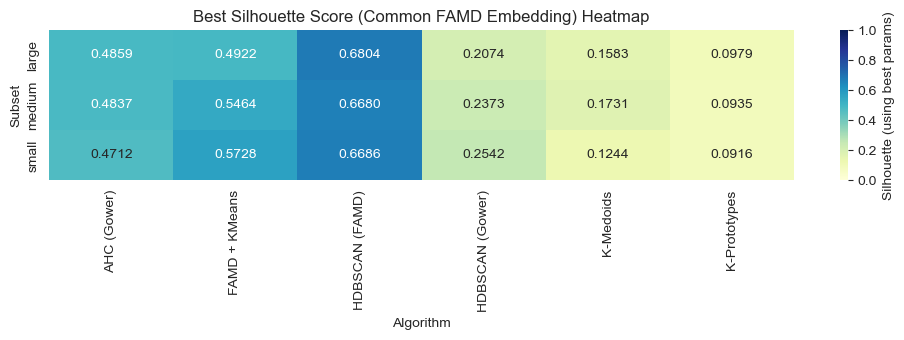

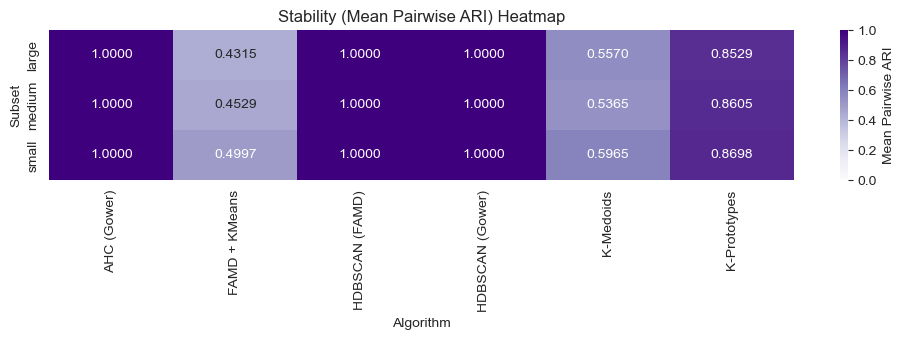

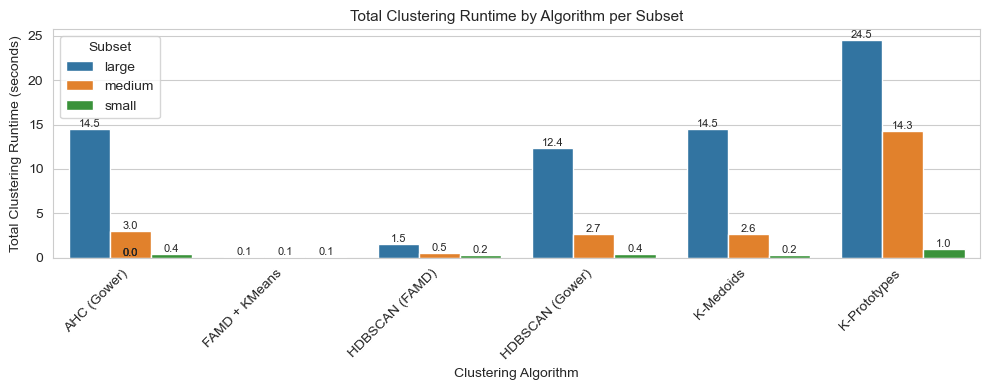


Combined Clustering Metrics (sample):


,subset,subset_size,algorithm_label,param,silhouette_native,silhouette_common,ARI,AMI,stability_ari,clustering_runtime,CH,DB
89,large,10000,AHC (Gower),2,0.416948,0.485891,0.003691,0.000906,1.000000,1.708376,571.341907,1.552769
93,large,10000,AHC (Gower),3,0.384301,0.456689,0.003721,0.001689,1.000000,1.605911,475.572998,1.130253
97,large,10000,AHC (Gower),4,0.349639,0.407398,0.003732,0.001687,1.000000,1.527029,319.262833,1.809080
121,large,10000,AHC (Gower),10,0.336134,0.081224,0.027379,0.039463,1.000000,1.595682,245.340587,2.110279
117,large,10000,AHC (Gower),9,0.341749,0.080462,0.027374,0.039672,1.000000,1.678560,271.208927,2.102800
113,large,10000,AHC (Gower),8,0.340712,0.079667,0.027349,0.039659,1.000000,1.548399,303.548326,1.955682
101,large,10000,AHC (Gower),5,0.438592,0.051495,-0.024090,0.010956,1.000000,1.562880,352.042887,2.345906
109,large,10000,AHC (Gower),7,0.415152,0.051423,-0.024087,0.010768,1.000000,1.646493,242.235714,1.992199
105,large,10000,AHC (Gower),6,0.424099,0.051284,-0.024090,0.010944,1.000000,1.584632,283.892632,2.105551
123,large,10000,FAMD + KMeans,10,0.492156,0.492156,-0.000515,0.028185,0.688269,0.005141,2098.658303,0.954914



Algorithm with Highest Silhouette Score per SUbset:


,subset,subset_size,algorithm_label,param,silhouette_native,silhouette_common,ARI,AMI,stability_ari,clustering_runtime,CH,DB
0,large,10000,HDBSCAN (FAMD),20,0.680393,0.680393,0.006398,0.035837,1.0,0.332164,2617.067361,0.349025
1,medium,5000,HDBSCAN (FAMD),20,0.667961,0.667961,0.007395,0.033077,1.0,0.086611,1773.347811,0.441102
2,small,2000,HDBSCAN (FAMD),20,0.668583,0.668583,0.003344,0.032444,1.0,0.042488,1258.101252,0.482609


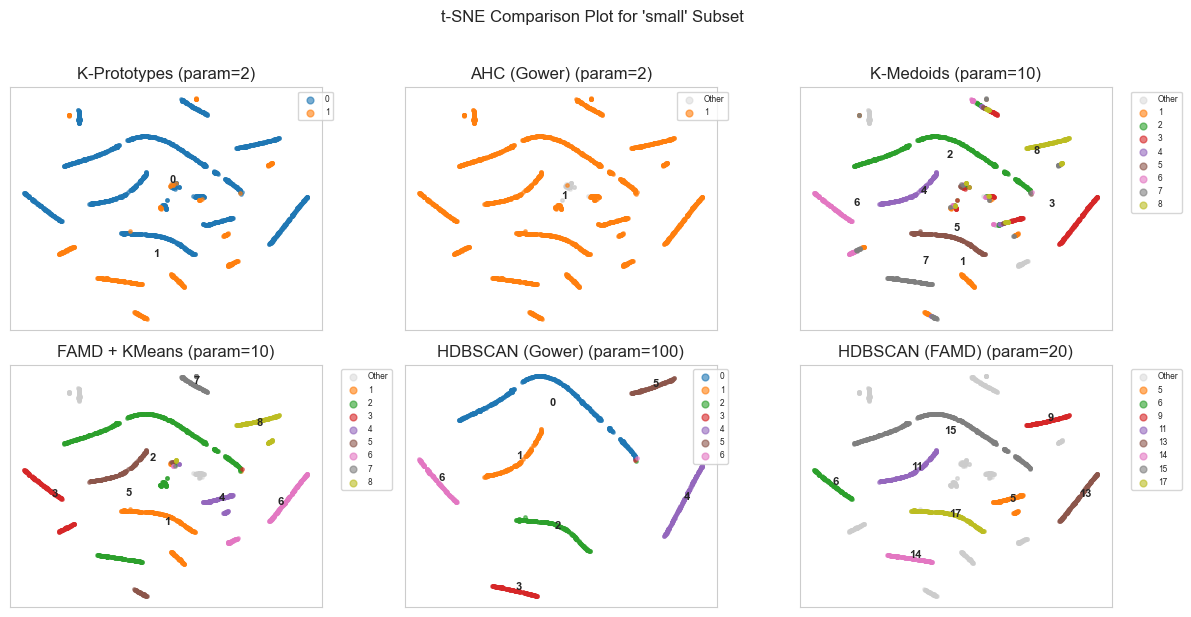

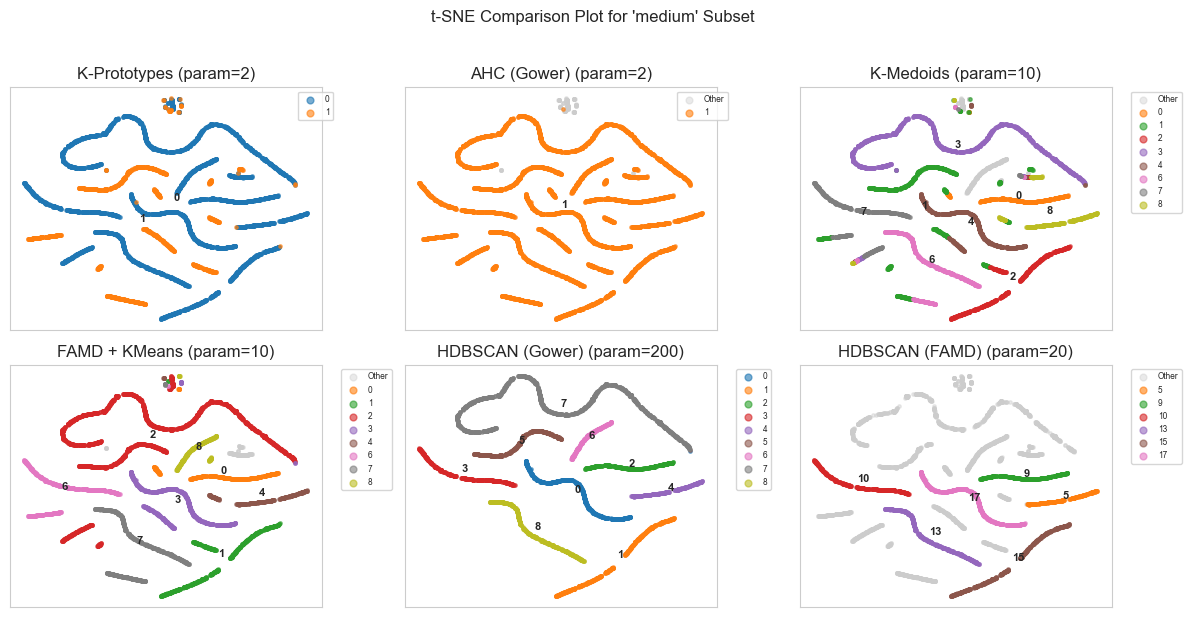

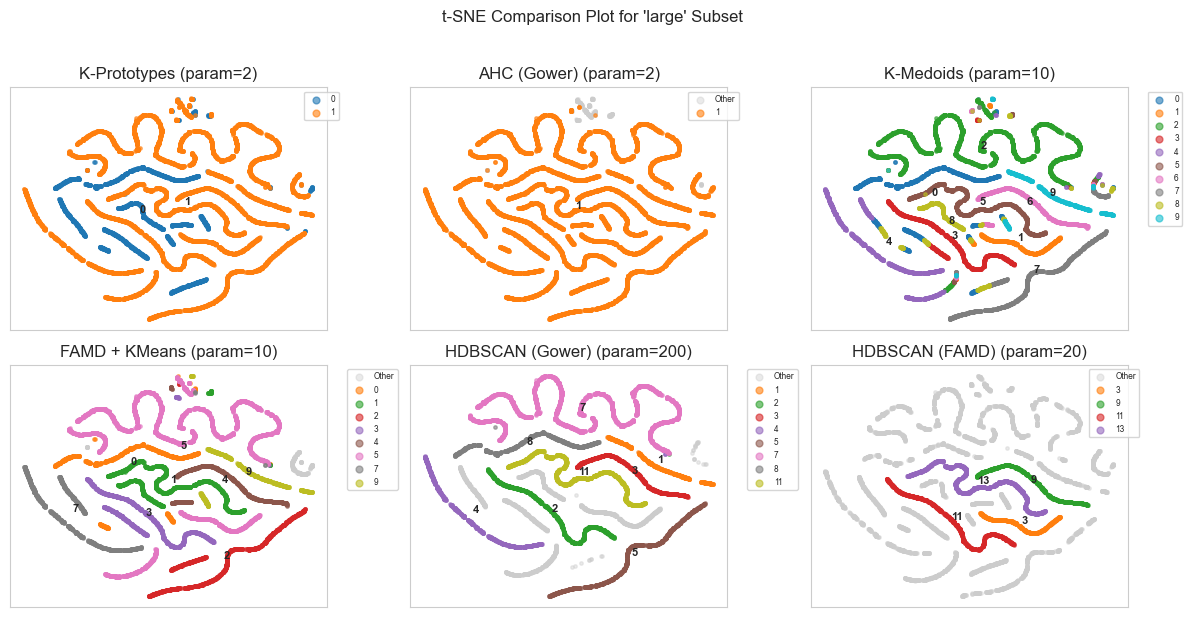

In [10]:
# output results and visualisation

# rename
algo_name_map = {
    "agg_gower": "AHC (Gower)",
    "famd_kmeans": "FAMD + KMeans",
    "hdbscan_famd": "HDBSCAN (FAMD)",
    "hdbscan_gower": "HDBSCAN (Gower)",
    "k_medoids": "K-Medoids",
    "k_prototypes": "K-Prototypes",
}

df_plot = df_res.copy()
df_plot["algorithm_label"] = (
    df_plot["algorithm"].map(algo_name_map).fillna(df_plot["algorithm"])
)

# silhouette heatmap
pivot_best = df_plot.groupby(["subset", "algorithm_label"], as_index=False)[
    "silhouette_common"
].max()
pivot_best = pivot_best.pivot(
    index="subset", columns="algorithm_label", values="silhouette_common"
)
plt.figure(figsize=(10, max(3, 0.5 * pivot_best.shape[0] + 2)))
sns.heatmap(
    pivot_best,
    annot=True,
    fmt=".4f",
    cmap="YlGnBu",
    vmin=0,
    vmax=1,
    cbar_kws={"label": "Silhouette (using best params)"},
)
plt.title(f"Best Silhouette Score (Common FAMD Embedding) Heatmap")
plt.xlabel("Algorithm")
plt.ylabel("Subset")
plt.tight_layout()
plt.show()

# stability heatmap
stab_pivot = df_plot.pivot_table(
    index="subset", columns="algorithm_label", values="stability_ari"
)
plt.figure(figsize=(10, max(3, 0.5 * stab_pivot.shape[0] + 2)))
sns.heatmap(
    stab_pivot,
    annot=True,
    fmt=".4f",
    cmap="Purples",
    vmin=0,
    vmax=1,
    cbar_kws={"label": "Mean Pairwise ARI"},
)
plt.title(f"Stability (Mean Pairwise ARI) Heatmap")
plt.xlabel("Algorithm")
plt.ylabel("Subset")
plt.tight_layout()
plt.show()

# runtime bar plot
runtime_plot = df_plot.groupby(["subset", "algorithm_label"], as_index=False)[
    "clustering_runtime"
].sum()
plt.figure(figsize=(10, 4))
ax = sns.barplot(
    data=runtime_plot, x="algorithm_label", y="clustering_runtime", hue="subset"
)
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1f}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=8,
    )
ax.set_xlabel("Clustering Algorithm", fontsize=10)
ax.set_ylabel("Total Clustering Runtime (seconds)", fontsize=10)
ax.set_title("Total Clustering Runtime by Algorithm per Subset", fontsize=11)
plt.xticks(rotation=45, ha="right")
ax.legend(title="Subset")
plt.tight_layout()
plt.show()

# combined metrics table
display_cols = [
    "subset",
    "subset_size",
    "algorithm_label",
    "param",
    "silhouette_native",
    "silhouette_common",
    "ARI",
    "AMI",
    "stability_ari",
    "clustering_runtime",
    "CH",
    "DB",
]
print("\nCombined Clustering Metrics (sample):")
display(
    df_plot[display_cols]
    .sort_values(
        ["subset", "algorithm_label", "silhouette_common"],
        ascending=[True, True, False],
    )
    .head(50)
)

# algorithm with highest silhouette
winner_by_slice = (
    df_plot.dropna(subset=["silhouette_common"])
    .sort_values("silhouette_common", ascending=False)
    .groupby(["subset"], as_index=False)
    .first()
)

print("\nAlgorithm with Highest Silhouette Score per SUbset:")
display(
    winner_by_slice[
        [
            "subset",
            "subset_size",
            "algorithm_label",
            "param",
            "silhouette_native",
            "silhouette_common",
            "ARI",
            "AMI",
            "stability_ari",
            "clustering_runtime",
            "CH",
            "DB",
        ]
    ]
)

# t-SNE comparison grid (uses common FAMD embedding)
COLLAPSE_THRESHOLD = 0.05
algorithms = df_plot["algorithm"].unique()

for subset in df_plot["subset"].unique():
    # loop for all subsets
    sub_df = df_plot[(df_plot["subset"] == subset)]
    if sub_df.empty:
        continue
    best_params = {}
    for algorithm in algorithms:
        # loop for all algorithms
        alg_rows = sub_df[sub_df["algorithm"] == algorithm]
        alg_rows = alg_rows.dropna(subset=["silhouette_common"])
        if alg_rows.empty:
            continue
        best_row = alg_rows.loc[alg_rows["silhouette_common"].idxmax()]
        best_params[algorithm] = int(best_row["param"])

    cache_entry = subset_cache.get(subset)
    if cache_entry is None:
        continue
    labels_store = cache_entry["labels_store"]
    Xf_map = cache_entry["X_famd"]
    df_mixed_sub = cache_entry["df_mixed"]
    if Xf_map is None or Xf_map.shape[0] != len(df_mixed_sub):
        continue

    emb = TSNE(n_components=2, random_state=RANDOM_STATE).fit_transform(Xf_map)

    cols = 3
    rows = math.ceil(len(algorithms) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
    axes = axes.flatten()
    fig.suptitle(f"t-SNE Comparison Plot for '{subset}' Subset ", y=1.02)

    for i, algorithm in enumerate(algorithms):
        ax = axes[i]
        if algorithm not in best_params:
            ax.axis("off")
            continue
        param = best_params[algorithm]
        key = (algorithm, param)
        if key not in labels_store:
            ax.axis("off")
            continue

        labels = np.asarray(labels_store[key])
        mask = labels != -1
        if mask.sum() == 0:
            ax.axis("off")
            continue

        labels_v = labels[mask]
        emb_v = emb[mask]
        freqs = pd.Series(labels_v).value_counts(normalize=True)
        major = set(freqs[freqs >= COLLAPSE_THRESHOLD].index)
        plot_lbl = np.where(np.isin(labels_v, list(major)), labels_v, -2)

        uniq = np.unique(plot_lbl)
        cmap = plt.get_cmap("tab10")
        color_map = {u: cmap(i % 10) for i, u in enumerate(uniq) if u != -2}
        color_map[-2] = (0.8, 0.8, 0.8, 0.4)

        for lbl in uniq:
            m = plot_lbl == lbl
            label_name = "Other" if lbl == -2 else str(lbl)
            ax.scatter(
                emb_v[m, 0],
                emb_v[m, 1],
                s=6,
                alpha=0.6 if lbl != -2 else 0.4,
                color=color_map[lbl],
                label=label_name,
            )
            if lbl != -2:
                centroid = emb_v[m].mean(axis=0)
                ax.text(centroid[0], centroid[1], str(lbl), fontsize=8, weight="bold")

        ax.set_title(f"{algorithm} (param={param})")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.legend(markerscale=2, fontsize=6, bbox_to_anchor=(1.05, 1))

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    for ax in fig.axes:
        orig_title = ax.get_title()
        for orig, pretty in algo_name_map.items():
            if orig in orig_title:
                new_title = orig_title.replace(orig, pretty)
                ax.set_title(new_title)
                break

    plt.tight_layout()
    plt.show()